In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ajoute les chemins vers tes fichiers de résultats
df_jetson_cpu = pd.read_csv("bench_jetson_cpu.csv")
df_jetson_gpu = pd.read_csv("bench_jetson_gpu.csv")
df_pc_cpu = pd.read_csv("history/bench_pc_cpu_3.csv")  # <-- Mets ici le chemin de ton csv PC


In [3]:
def clean_df(df, platform, backend):
    df = df.copy()
    df['platform'] = platform
    df['backend'] = backend
    if 'status' not in df.columns:
        df['status'] = 'OK'
    # Nettoie les strings éventuelles
    df.columns = [c.strip().lower() for c in df.columns]
    return df

df_jetson_cpu = clean_df(df_jetson_cpu, "Jetson", "cpu")
df_jetson_gpu = clean_df(df_jetson_gpu, "Jetson", "gpu")
df_pc_cpu     = clean_df(df_pc_cpu, "PC", "cpu")

df_all = pd.concat([df_jetson_cpu, df_jetson_gpu, df_pc_cpu], ignore_index=True)
df_all['graph'] = df_all['graph'].str.extract(r'([^/\\]+)$')  # ne garde que le nom du fichier


In [4]:
print("Nombre total de benchmarks:", len(df_all))
print(df_all.groupby(['platform', 'backend', 'algo', 'graph', 'status']).size().unstack(fill_value=0))
print("\nListe des graphes par plateforme et backend:")
print(df_all.groupby(['platform', 'backend'])['graph'].unique())


Nombre total de benchmarks: 198
status                                            OK
platform backend algo     graph                     
Jetson   cpu     bfs      CA-GrQc.edgelist         8
                          ca-GrQc.edgelist         8
                          email-Eu-core.edgelist   8
                          roadNet-PA.edgelist      8
                          web-Google.edgelist      8
                 pagerank CA-GrQc.edgelist         6
                          ca-GrQc.edgelist         6
                          email-Eu-core.edgelist   6
                          roadNet-PA.edgelist      6
                          web-Google.edgelist      6
                 sssp     CA-GrQc.edgelist         8
                          ca-GrQc.edgelist         8
                          email-Eu-core.edgelist   8
                          roadNet-PA.edgelist      8
                          web-Google.edgelist      8
         gpu     bfs      CA-GrQc.edgelist         8
              

<Figure size 1200x600 with 0 Axes>

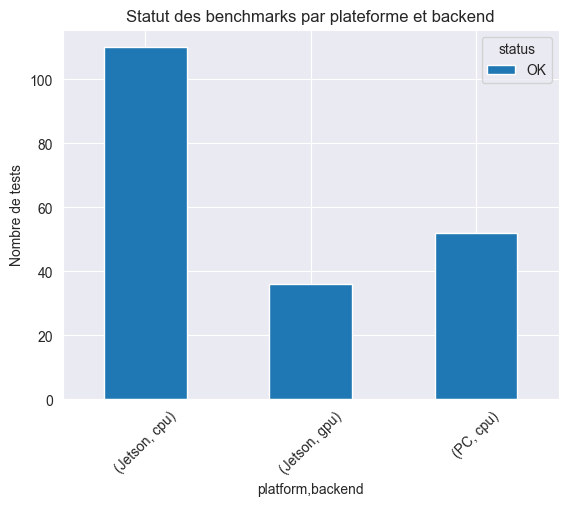

In [5]:
plt.figure(figsize=(12,6))
status_counts = df_all.groupby(['platform', 'backend', 'status']).size().unstack(fill_value=0)
status_counts.plot(kind='bar', stacked=True)
plt.title("Statut des benchmarks par plateforme et backend")
plt.ylabel("Nombre de tests")
plt.xticks(rotation=45)
plt.show()


MultiIndex([('Jetson', 'cpu'),
            ('Jetson', 'gpu'),
            (    'PC', 'cpu')],
           names=['platform', 'backend'])


backend                                 cpu        gpu  speedup_gpu_vs_cpu
graph                  algo                                               
CA-GrQc.edgelist       bfs         0.723798  10.379839            0.069731
                       pagerank   43.290123   0.014632         2958.491212
                       sssp        1.107845   0.028203           39.280565
ca-GrQc.edgelist       bfs         0.722266        NaN                 NaN
                       pagerank   43.408852        NaN                 NaN
                       sssp        1.101884        NaN                 NaN
email-Eu-core.edgelist bfs         0.199503   3.159900            0.063136
                       pagerank   10.591074   0.014513          729.764659
                       sssp        0.455859   0.011411           39.948669
roadNet-PA.edgelist    bfs        75.702553        NaN                 NaN
                       pagerank   24.946594        NaN                 NaN
                       sssp      140.827038        NaN                 NaN
web-Google.edgelist    bfs        95.715817        NaN                 NaN
                       pagerank   20.251375        NaN                 NaN
                       sssp      173.752498        NaN                 NaN

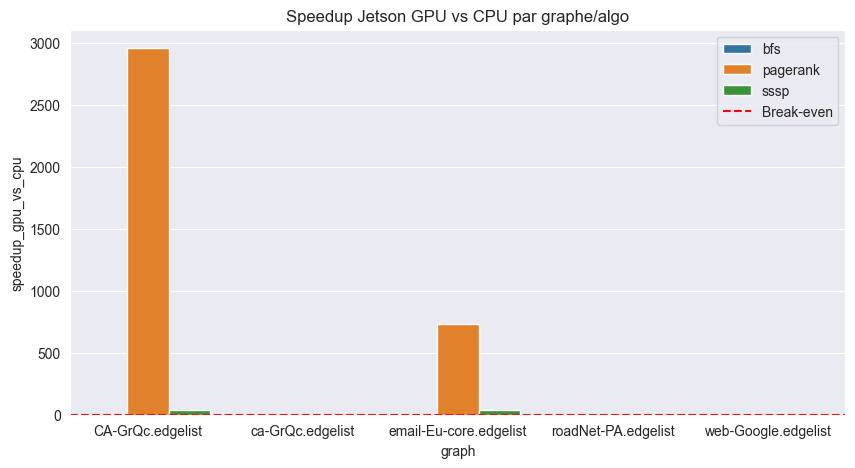

In [6]:
# On suppose df_all déjà chargé
df_ok = df_all[df_all['status'] == 'OK'].copy()

# Pivot table MultiIndex : [graph, algo], columns=[platform, backend]
pivot = df_ok.pivot_table(index=['graph','algo'], columns=['platform','backend'], values='time_s')

# On affiche pour debug :
print(pivot.columns)  # Tu verras que ce sont des tuples

# Jetson seulement
pivot_jetson = pivot['Jetson']   # <--- on enlève un niveau (backend: cpu, gpu)
pivot_jetson['speedup_gpu_vs_cpu'] = pivot_jetson['cpu'] / pivot_jetson['gpu']
display(pivot_jetson[['cpu','gpu','speedup_gpu_vs_cpu']])

plt.figure(figsize=(10,5))
sns.barplot(
    data=pivot_jetson.reset_index(),
    x="graph",
    y="speedup_gpu_vs_cpu",
    hue="algo"
)
plt.title("Speedup Jetson GPU vs CPU par graphe/algo")
plt.axhline(1, color='red', linestyle='--', label="Break-even")
plt.legend()
plt.show()

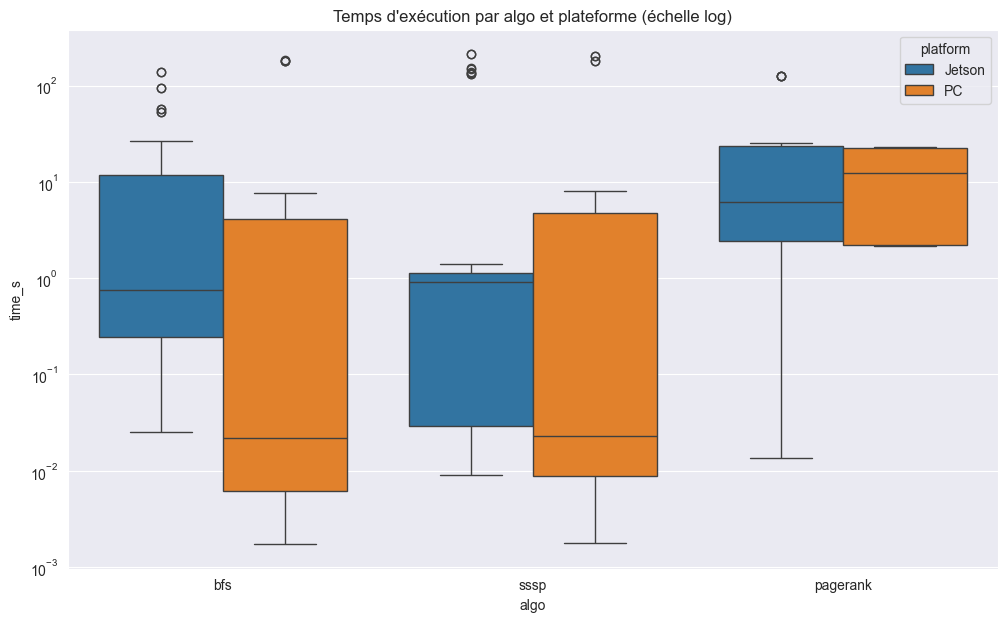

In [7]:
plt.figure(figsize=(12,7))
sns.boxplot(data=df_ok, x="algo", y="time_s", hue="platform")
plt.yscale("log")
plt.title("Temps d'exécution par algo et plateforme (échelle log)")
plt.show()


In [8]:
# Charge le nombre d’arêtes/nœuds si dispo
# Sinon, tu peux parser les noms de fichiers ou ajouter une table à la main (optionnel)
# Exemple:
graph_sizes = {
    "CA-GrQc.edgelist": (5242, 14496),
    "email-Eu-core.edgelist": (1005, 25571),
    "roadNet-PA.edgelist": (1088092, 3083796),
    "web-Google.edgelist": (875713, 5105039)
}
df_all['num_nodes'] = df_all['graph'].map(lambda g: graph_sizes.get(g, (np.nan,np.nan))[0])
df_all['num_edges'] = df_all['graph'].map(lambda g: graph_sizes.get(g, (np.nan,np.nan))[1])

# Analyse taille max OK par plateforme/backend
df_max_ok = df_all[df_all['status']=='OK'].groupby(['platform','backend'])[['num_edges']].max()
print("Taille max de graphe réussi (nombre d’arêtes) par plateforme/backend :")
print(df_max_ok)

# Analyse des OOM
df_oom = df_all[df_all['status']=='OOM']
print("Benchmarks échoués par manque de mémoire :")
display(df_oom[['platform','backend','graph','algo','num_edges']])


Taille max de graphe réussi (nombre d’arêtes) par plateforme/backend :
                  num_edges
platform backend           
Jetson   cpu      5105039.0
         gpu        25571.0
PC       cpu      3083796.0
Benchmarks échoués par manque de mémoire :


,platform,backend,graph,algo,num_edges


In [9]:
def analyze_bottlenecks(df):
    print("\n--- Goulets d’étranglement détectés ---")
    for platform in df['platform'].unique():
        for backend in df[df['platform']==platform]['backend'].unique():
            sub = df[(df['platform']==platform)&(df['backend']==backend)]
            # Taille max OK, min OOM
            max_ok = sub[sub['status']=='OK']['num_edges'].max()
            min_oom = sub[sub['status']=='OOM']['num_edges'].min()
            print(f"Plateforme: {platform}/{backend}")
            print(f"  Taille max OK: {max_ok}, Taille min OOM: {min_oom}")
            # Temps max OK, min TIMEOUT si dispo
            max_time = sub[sub['status']=='OK']['time_s'].max()
            min_timeout = sub[sub['status']=='TIMEOUT']['num_edges'].min() if 'TIMEOUT' in sub['status'].values else None
            print(f"  Temps max OK: {max_time}s, Taille min TIMEOUT: {min_timeout}")

analyze_bottlenecks(df_all)



--- Goulets d’étranglement détectés ---
Plateforme: Jetson/cpu
  Taille max OK: 5105039.0, Taille min OOM: nan
  Temps max OK: 211.421307s, Taille min TIMEOUT: None
Plateforme: Jetson/gpu
  Taille max OK: 25571.0, Taille min OOM: nan
  Temps max OK: 26.491093s, Taille min TIMEOUT: None
Plateforme: PC/cpu
  Taille max OK: 3083796.0, Taille min OOM: nan
  Temps max OK: 203.205457s, Taille min TIMEOUT: None


In [10]:
def auto_summary(df):
    print("Synthèse auto des benchmarks :")
    for platform in df['platform'].unique():
        for backend in df[df['platform']==platform]['backend'].unique():
            print(f"\nPlateforme {platform} / {backend} :")
            ok = df[(df['platform']==platform)&(df['backend']==backend)&(df['status']=='OK')]
            oom = df[(df['platform']==platform)&(df['backend']==backend)&(df['status']=='OOM')]
            print(f"  Tests OK : {len(ok)}, OOM : {len(oom)}")
            if not ok.empty:
                print(f"    Taille max OK (arêtes) : {ok['num_edges'].max()}")
            if not oom.empty:
                print(f"    Taille min OOM (arêtes) : {oom['num_edges'].min()}")

auto_summary(df_all)


Synthèse auto des benchmarks :

Plateforme Jetson / cpu :
  Tests OK : 110, OOM : 0
    Taille max OK (arêtes) : 5105039.0

Plateforme Jetson / gpu :
  Tests OK : 36, OOM : 0
    Taille max OK (arêtes) : 25571.0

Plateforme PC / cpu :
  Tests OK : 52, OOM : 0
    Taille max OK (arêtes) : 3083796.0


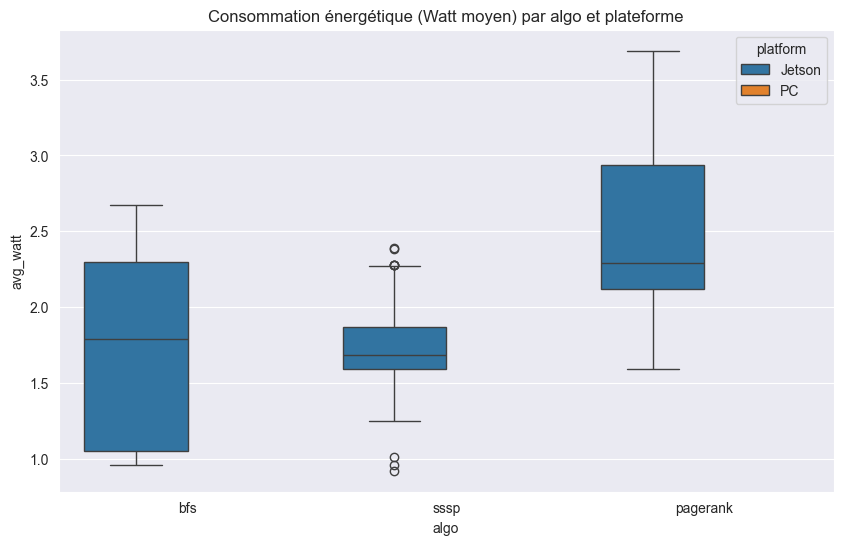

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_ok, x="algo", y="avg_watt", hue="platform")
plt.title("Consommation énergétique (Watt moyen) par algo et plateforme")
plt.show()


In [29]:
import glob

def show_profile_stats(profile_file, sort_by='cumulative', top_n=20):
    p = pstats.Stats(profile_file)
    print(f"Profil : {profile_file}")
    p.strip_dirs().sort_stats(sort_by).print_stats(top_n)

profile_files = sorted(glob.glob("profile_*.pstats"))
for pf in profile_files:
    show_profile_stats(pf, sort_by='cumulative', top_n=5)
    print("\n"+"-"*80+"\n")


Profil : profile_bfs_cpu.pstats
Sat May 17 18:08:52 2025    profile_bfs_cpu.pstats

         474891 function calls (474853 primitive calls) in 0.438 seconds

   Ordered by: cumulative time
   List reduced from 284 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.213    0.213 graph_loader.py:5(load_graph)
      5/2    0.000    0.000    0.207    0.104 decorators.py:787(func)
        1    0.000    0.000    0.206    0.206 <class 'networkx.utils.decorators.argmap'> compilation 6:1(argmap_read_edgelist_1)
      3/1    0.000    0.000    0.206    0.206 backends.py:959(__call__)
        1    0.000    0.000    0.206    0.206 edgelist.py:300(read_edgelist)



--------------------------------------------------------------------------------

Profil : profile_pagerank_cpu.pstats
Sat May 17 18:09:47 2025    profile_pagerank_cpu.pstats

         610442 function calls (610405 primitive calls) in 0.715 seconds

   Order

In [32]:
import glob, pstats

def extract_top_functions(profile_file, top_n=10, sort_by='cumulative'):
    p = pstats.Stats(profile_file)
    p.strip_dirs().sort_stats(sort_by)
    entries = []
    for func, stat in list(p.stats.items())[:top_n]:
        filename, lineno, funcname = func
        cc, nc, tt, ct, callers = stat
        entries.append({
            "profile_file": profile_file,
            "function": f"{funcname} ({filename}:{lineno})",
            "callcount": cc,
            "cumtime": ct,
            "tottime": tt,
        })
    return entries

all_stats = []
for pf in glob.glob("profile_*.pstats"):
    all_stats += extract_top_functions(pf, top_n=10)

import pandas as pd
df_prof = pd.DataFrame(all_stats)
display(df_prof)


,profile_file,function,callcount,cumtime,tottime
0,profile_bfs_cpu.pstats,release (<frozen importlib._bootstrap>:372),2,0.000010,0.000007
1,profile_bfs_cpu.pstats,acquire (<frozen importlib._bootstrap>:304),2,0.000048,0.000016
2,profile_bfs_cpu.pstats,_get_module_lock (<frozen importlib._bootstrap...,2,0.000021,0.000013
3,profile_bfs_cpu.pstats,_init_module_attrs (<frozen importlib._bootstr...,2,0.000048,0.000010
4,profile_bfs_cpu.pstats,_load_unlocked (<frozen importlib._bootstrap>:...,2,0.001648,0.000010
5,profile_bfs_cpu.pstats,_find_and_load_unlocked (<frozen importlib._bo...,1,0.003630,0.000027
6,profile_bfs_cpu.pstats,_handle_fromlist (<frozen importlib._bootstrap...,1,0.000011,0.000001
7,profile_bfs_cpu.pstats,_find_spec (<frozen importlib._bootstrap>:1240),2,0.001917,0.000031
8,profile_bfs_cpu.pstats,_find_and_load (<frozen importlib._bootstrap>:...,1,0.003737,0.000044
9,profile_bfs_cpu.pstats,__new__ (enum.py:1152),27,0.000006,0.000006


In [33]:
import re

def extract_info_from_filename(filename):
    m = re.match(r'profile_(\w+)_(\w+)_datasets_([\w\-\.]+)_(\w+)_(\w+)_(\w+)_(\w+).txt', filename)
    if m:
        return dict(
            platform=m[1],
            backend=m[2],
            graph=m[3],
            algo=m[4],
            mode=m[5],
            access=m[6],
            activation=m[7]
        )
    else:
        return {}

infos = [extract_info_from_filename(f) for f in df_prof["profile_file"]]
infos_df = pd.DataFrame(infos)
df_prof = pd.concat([df_prof, infos_df], axis=1)
display(df_prof)


,profile_file,function,callcount,cumtime,tottime
0,profile_bfs_cpu.pstats,release (<frozen importlib._bootstrap>:372),2,0.000010,0.000007
1,profile_bfs_cpu.pstats,acquire (<frozen importlib._bootstrap>:304),2,0.000048,0.000016
2,profile_bfs_cpu.pstats,_get_module_lock (<frozen importlib._bootstrap...,2,0.000021,0.000013
3,profile_bfs_cpu.pstats,_init_module_attrs (<frozen importlib._bootstr...,2,0.000048,0.000010
4,profile_bfs_cpu.pstats,_load_unlocked (<frozen importlib._bootstrap>:...,2,0.001648,0.000010
5,profile_bfs_cpu.pstats,_find_and_load_unlocked (<frozen importlib._bo...,1,0.003630,0.000027
6,profile_bfs_cpu.pstats,_handle_fromlist (<frozen importlib._bootstrap...,1,0.000011,0.000001
7,profile_bfs_cpu.pstats,_find_spec (<frozen importlib._bootstrap>:1240),2,0.001917,0.000031
8,profile_bfs_cpu.pstats,_find_and_load (<frozen importlib._bootstrap>:...,1,0.003737,0.000044
9,profile_bfs_cpu.pstats,__new__ (enum.py:1152),27,0.000006,0.000006
